# Convolutional & Denoising Autoencoders

The insights from Chapter 17, Convolutional Neural Networks, suggest we incorporate convolutional layers into the autoencoder to extract information characteristic of the grid-like structure of image data.

Source: https://blog.keras.io/building-autoencoders-in-keras.html

## Imports & Settings

In [1]:
%matplotlib inline

from pathlib import Path
import pandas as pd
import numpy as np
from numpy.random import choice

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.datasets import fashion_mnist

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [3]:
n_classes = 10 # all examples have 10 classes

In [4]:
sns.set_style('white')
cmap = sns.color_palette('Paired', n_classes)

In [5]:
results_path = Path('results', 'fashion_mnist')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Fashion MNIST Data

In [6]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [7]:
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [8]:
class_dict = {0: 'T-shirt/top',
              1: 'Trouser',
              2: 'Pullover',
              3: 'Dress',
              4: 'Coat',
              5: 'Sandal',
              6: 'Shirt',
              7: 'Sneaker',
              8: 'Bag',
              9: 'Ankle boot'}
classes = list(class_dict.keys())

## Reshape & normalize Fashion MNIST data

In [9]:
image_size = 28

In [10]:
def data_prep_conv(x, size=image_size):
    return x.reshape(-1, size, size, 1).astype('float32')/255

In [11]:
X_train_scaled = data_prep_conv(X_train)
X_test_scaled = data_prep_conv(X_test)

In [12]:
X_train_scaled.shape, X_test_scaled.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

## Combine training steps into function

In [13]:
def train_autoencoder(path, model, x_train=X_train_scaled, x_test=X_test_scaled):
    callbacks = [EarlyStopping(patience=5, restore_best_weights=True),
                 ModelCheckpoint(filepath=path, save_best_only=True, save_weights_only=True)]
    model.fit(x=x_train, y=x_train, epochs=100, validation_split=.1, callbacks=callbacks)
    model.load_weights(path)
    mse = model.evaluate(x=x_test, y=x_test)
    return model, mse

## Convolutional Autoencoder

We define a three-layer encoder that uses 2D convolutions with 32, 16, and 8 filters, respectively, ReLU activations, and 'same' padding to maintain the input size. The resulting encoding size at the third layer is 4 x 4 x 8 = 128, higher than for the preceding examples:

### 3-dim input

In [14]:
input_ = Input(shape=(28, 28, 1), name='Input_3D')

### Encoding Layers

In [15]:
x = Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=16,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_2')(x)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_2')(x)
x = Conv2D(filters=8,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Encoding_Conv_3')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2),
                            padding='same',
                            name='Encoding_Max_3')(x)

We also define a matching decoder that reverses the number of filters and uses 2D upsampling instead of max pooling to reverse the reduction of the filter sizes. The three-layer autoencoder has 12,785 parameters, a little more than 5% of the capacity of the preceding deep autoencoder.

In [16]:
x = Conv2D(filters=8,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=16,
           kernel_size=(3, 3),
           activation='relu',
           padding='same',
           name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
x = Conv2D(filters=32,
           kernel_size=(3, 3),
           activation='relu',
           name='Decoding_Conv_3')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_3')(x)
decoded_conv = Conv2D(filters=1,
                      kernel_size=(3, 3),
                      activation='sigmoid',
                      padding='same',
                      name='Decoding_Conv_4')(x)

In [17]:
autoencoder_conv = Model(input_, decoded_conv)
autoencoder_conv.compile(optimizer='adam', loss='mse')

In [18]:
autoencoder_conv.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_3D (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
Encoding_Conv_1 (Conv2D)     (None, 28, 28, 32)        320       
_________________________________________________________________
Encoding_Max_1 (MaxPooling2D (None, 14, 14, 32)        0         
_________________________________________________________________
Encoding_Conv_2 (Conv2D)     (None, 14, 14, 16)        4624      
_________________________________________________________________
Encoding_Max_2 (MaxPooling2D (None, 7, 7, 16)          0         
_________________________________________________________________
Encoding_Conv_3 (Conv2D)     (None, 7, 7, 8)           1160      
_________________________________________________________________
Encoding_Max_3 (MaxPooling2D (None, 4, 4, 8)           0     

In [19]:
path = (results_path / 'autencoder_conv.32.weights.hdf5').as_posix()

In [20]:
autoencoder_deep, mse = train_autoencoder(path, 
                                          autoencoder_conv, 
                                          x_train=X_train_scaled, 
                                          x_test=X_test_scaled)

Epoch 1/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0230 - val_loss: 0.0177
Epoch 2/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0156 - val_loss: 0.0146
Epoch 3/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0140 - val_loss: 0.0135
Epoch 4/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 5/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0124 - val_loss: 0.0124
Epoch 6/100
1688/1688 [==============================] - 7s 4ms/step - loss: 0.0119 - val_loss: 0.0115
Epoch 7/100
1688/1688 [==============================] - 8s 5ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 8/100
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 9/100
1688/1688 [==============================] - 8s 4ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 10/100
1688/1688 [==============================] - 7s 4ms/step - l

Training stops after 75 epochs and results in a further 9% reduction of the test RMSE, due to a combination of the ability of convolutional filters to learn more efficiently from image data and the larger encoding size.

In [21]:
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

'MSE: 0.0082 | RMSE 0.0905'

In [22]:
autoencoder_conv.load_weights(path)

In [23]:
reconstructed_images = autoencoder_deep.predict(X_test_scaled)
reconstructed_images.shape

(10000, 28, 28, 1)

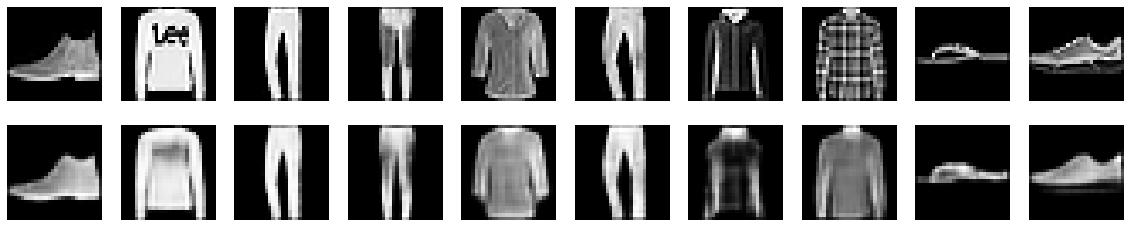

In [24]:
fig, axes = plt.subplots(ncols=n_classes, nrows=2, figsize=(20, 4))
for i in range(n_classes):
    
    axes[0, i].imshow(X_test_scaled[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')

    axes[1, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[1, i].axis('off')

## Denoising Autoencoder

The application of an autoencoder to a denoising task only affects the training stage. In this example, we add noise to the Fashion MNIST data from a standard normal distribution while maintaining the pixel values in the range of [0, 1], as follows:

In [25]:
def add_noise(x, noise_factor=.3):
    return np.clip(x  + noise_factor * np.random.normal(size=x.shape), 0, 1)

In [26]:
X_train_noisy = add_noise(X_train_scaled)
X_test_noisy = add_noise(X_test_scaled)

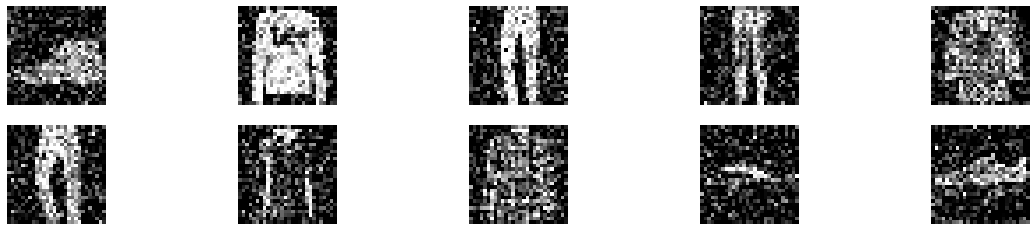

In [27]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 4))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.imshow(X_test_noisy[i].reshape(28, 28), cmap='gray')
    ax.axis('off')

In [28]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_1')(input_)
x = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Encoding_Conv_2')(x)
encoded_conv = MaxPooling2D(pool_size=(2, 2), padding='same', name='Encoding_Max_3')(x)

In [29]:
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_1')(encoded_conv)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_1')(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', name='Decoding_Conv_2')(x)
x = UpSampling2D(size=(2, 2), name='Decoding_Upsample_2')(x)
decoded_conv = Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same', name='Decoding_Conv_4')(x)

In [30]:
autoencoder_denoise = Model(input_, decoded_conv)
autoencoder_denoise.compile(optimizer='adam', loss='mse')

In [35]:
path = (results_path / 'autencoder_denoise.32.weights.hdf5').as_posix()

In [36]:
callbacks = [EarlyStopping(patience=5,
                           restore_best_weights=True),
             ModelCheckpoint(filepath=path,
                             save_best_only=True,
                             save_weights_only=True)]

We then proceed to train the convolutional autoencoder on noisy input with the objective to learn how to generate the uncorrupted originals:

In [37]:
autoencoder_denoise.fit(x=X_train_noisy,
                        y=X_train_scaled,
                        epochs=100,
                        batch_size=128,
                        shuffle=True,
                        validation_split=.1,
                        callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0095 - val_loss: 0.0094
Epoch 2/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 3/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0093 - val_loss: 0.0093
Epoch 4/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0093 - val_loss: 0.0092
Epoch 5/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0092 - val_loss: 0.0093
Epoch 7/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 8/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 9/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 10/100
422/422 [==============================] - 2s 6ms/step - loss: 0.0090 - val_lo

In [38]:
autoencoder_denoise.load_weights(path)

In [39]:
mse = autoencoder_denoise.evaluate(x=X_test_noisy, y=X_test_scaled)
f'MSE: {mse:.4f} | RMSE {mse**.5:.4f}'

313/313 [==============================] - 1s 2ms/step - loss: 0.0085


'MSE: 0.0085 | RMSE 0.0921'

## Visualize Reconstructed Images

The following figure shows, from top to bottom, the original images as well as the noisy and denoised versions. It illustrates that the autoencoder is successful in producing compressed encodings from the noisy images that are quite similar to those produced from the original images:

In [40]:
reconstructed_images = autoencoder_denoise.predict(X_test_noisy)
reconstructed_images.shape

(10000, 28, 28, 1)

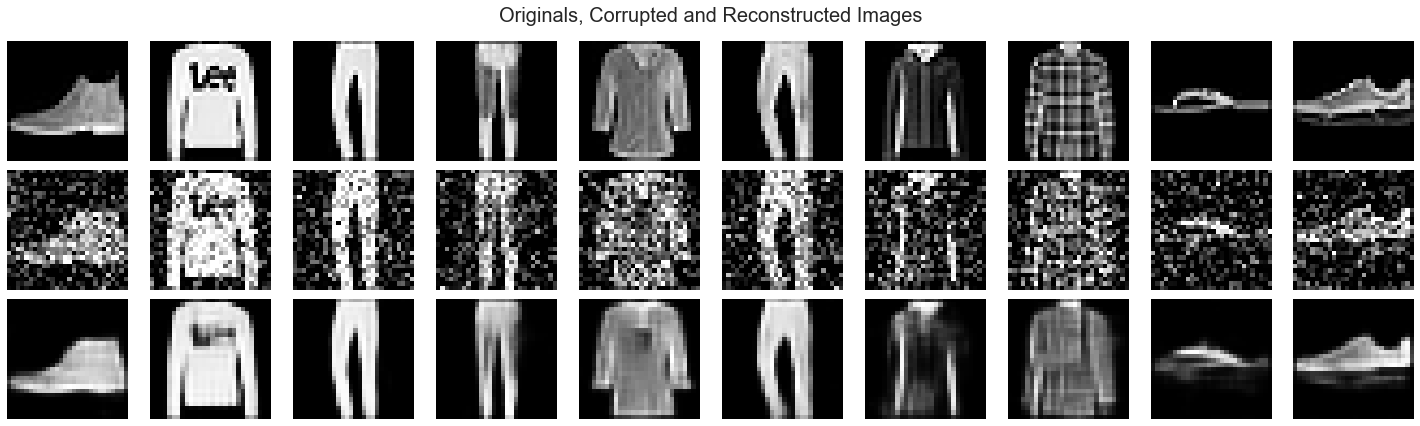

In [41]:
fig, axes = plt.subplots(ncols=n_classes, nrows=3, figsize=(20, 6))
for i in range(n_classes):
    axes[0, i].imshow(X_test[i].reshape(image_size, image_size), cmap='gray')
    axes[0, i].axis('off')
    
    axes[1, i].imshow(X_test_noisy[i].reshape(image_size, image_size), cmap='gray')
    axes[1, i].axis('off')

    axes[2, i].imshow(reconstructed_images[i].reshape(image_size, image_size) , cmap='gray')
    axes[2, i].axis('off')
fig.suptitle('Originals, Corrupted and Reconstructed Images', fontsize=20)
fig.tight_layout()
fig.subplots_adjust(top=.9)
fig.savefig(results_path / 'autoencoder_denoising', dpi=300)